## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

Las dimensiones de la imagen son: (1024, 1024, 3)


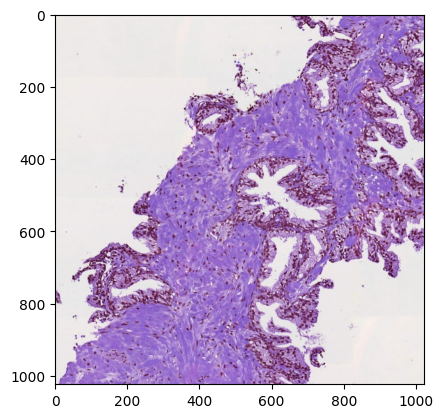

[[0.98840997 0.97551799 0.98344336 ... 0.52007413 0.59853337 0.56469678]
 [0.98840997 0.97551799 0.98344336 ... 0.58829161 0.6971513  0.70282734]
 [0.98840997 0.97551799 0.98344336 ... 0.54898333 0.69421082 0.77259328]
 ...
 [0.96761063 0.95391464 0.95857018 ... 0.96401619 0.95628723 0.9568885 ]
 [0.96761063 0.95391464 0.95857018 ... 0.96401619 0.95628723 0.9568885 ]
 [0.96761063 0.95391464 0.95857018 ... 0.96401619 0.95628723 0.9568885 ]]


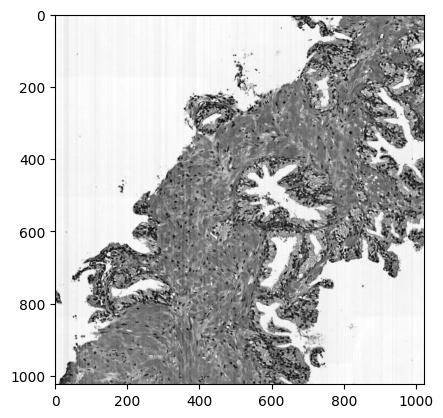

In [1]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
img = io.imread('histo_1.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Las dimensiones de la imagen son:', np.shape(RGB_img))
plt.imshow(RGB_img, cmap='gray')
plt.show()
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
#Necesitamos convertir la imagen a blanco y negro para reducir la dimensionalidad a 2 para poder normalizar los valores.
from sklearn import preprocessing
from skimage import color
imgGray = color.rgb2gray(RGB_img)
normalizer = preprocessing.MinMaxScaler()
img_norm = normalizer.fit_transform(imgGray)
print(img_norm)

#Visualizar la imagen
plt.imshow(img_norm, cmap='gray')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

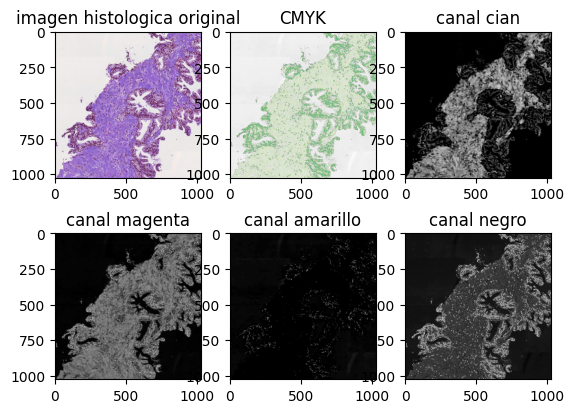

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
rgb= RGB_img.copy()
rgb_p= rgb.astype('uint8')/255
with np.errstate(invalid='ignore', divide='ignore'):
    K= 1 - np.max(rgb_p, axis=2)
    #Extraemos el canal de color magenta en relacion a la siguiente ecuación:
    C= (1-rgb_p[:,:,0]-K)/(1-K)
    M= (1-rgb_p[:,:,1]-K)/(1-K)
    Y= (1-rgb_p[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)
    
# Visualizar la imagen del canal magenta
fig, ax= plt.subplots(2,3)
ax[0,0].imshow(RGB_img, cmap='gray'), ax[0,0].set_title('imagen histologica original')
ax[0,1].imshow(CMYK.astype('uint8'), cmap='gray'), ax[0,1].set_title('CMYK')
ax[0,2].imshow(C.astype('uint8'), cmap='gray'), ax[0,2].set_title('canal cian')
ax[1,0].imshow(M.astype('uint8'), cmap='gray'), ax[1,0].set_title('canal magenta')
ax[1,1].imshow(Y.astype('uint8'), cmap='gray'), ax[1,1].set_title('canal amarillo')
ax[1,2].imshow(K.astype('uint8'), cmap='gray'), ax[1,2].set_title('canal negro')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

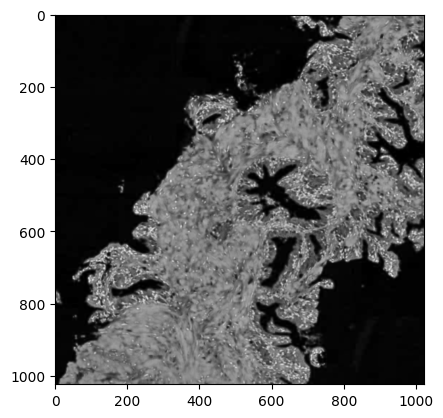

[0 1]


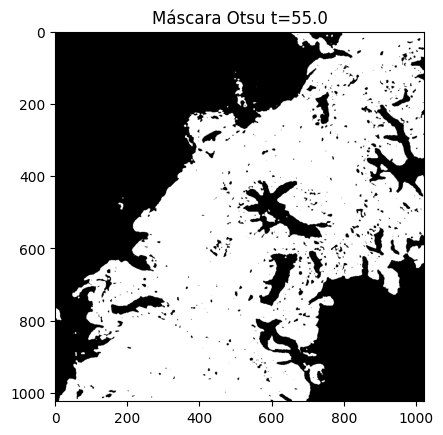

In [3]:
# Aplicar un filtro gaussiano de tamaño 5x5 
img_gaus = cv2.GaussianBlur(M.astype('uint8'), (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.imshow(img_gaus, cmap='gray')
plt.show()

# Método de Otsu de manera que los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
#img_otsu= (img_gaus*255).astype('uint8') 
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

t, mask = cv2.threshold(img_gaus,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask))

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

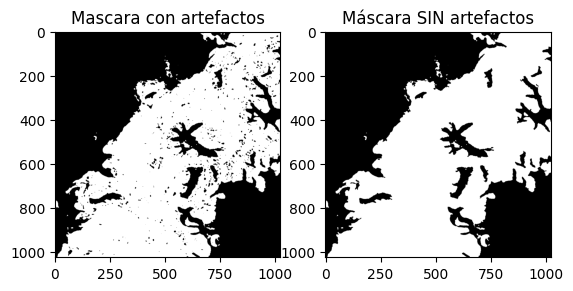

In [22]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
#PASAR A BOOL
from skimage import morphology
mask_clean= morphology.remove_small_objects(mask, min_size=300).astype('bool')
mask_clean= morphology.remove_small_holes(mask_clean, area_threshold=300).astype('uint8')


# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizar la máscara resultante:
fig, ax= plt.subplots(1,2)
ax[0].imshow(mask, cmap='gray'), ax[0].set_title('Mascara con artefactos')
ax[1].imshow(mask_clean, cmap='gray'), ax[1].set_title('Máscara SIN artefactos')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

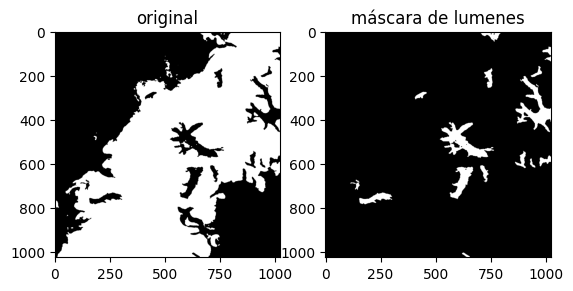

In [23]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

# Crear una copia de la imagen
mask_clean_c = mask_clean.copy().astype('uint8')

# Definir una imagen negra de referencia
h, w = mask_clean_c.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) y en la esquina inferior derecha (1000,1000).
cv2.floodFill(mask_clean_c, ref, (0,0),1) # utilizamos el 0 en la última posición porque queremos obtener el fondo negro. Lumenes en blanco
cv2.floodFill(mask_clean_c, ref, (1000,1000),1)

mask_final = np.logical_xor(mask_clean_c,1).astype('uint8') # Se invierten los 1s por 0s
# Visualizar la máscara resultante. 
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_clean, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask_final, cmap='gray'), ax[1].set_title('máscara de lumenes')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

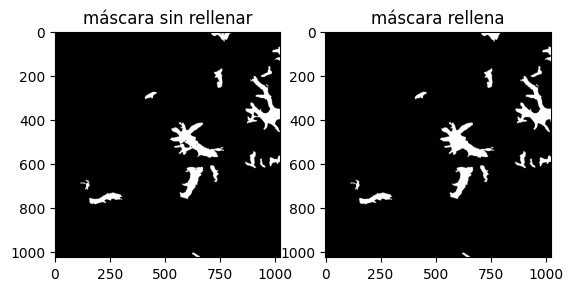

In [24]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
from scipy import ndimage
mask_fill= ndimage.binary_fill_holes(mask_final)
# Visualizar la máscara resultante
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_final, cmap='gray'), ax[0].set_title('máscara sin rellenar')
ax[1].imshow(mask_fill, cmap='gray'), ax[1].set_title('máscara rellena')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

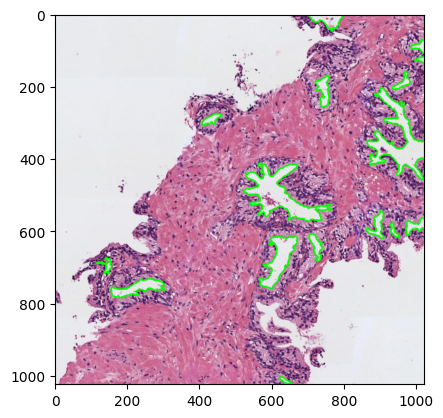

In [25]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Detección de bordes de Canny 
conts,_ = cv2.findContours(mask_fill.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imagen = cv2.drawContours(img, conts, -1, (0,255,0), 3)

# Visualizar la imagen superpuesta
plt.imshow(imagen, cmap='gray')
plt.show()


#### 7) Identificar y cropear el lumen más grande

8
13578.0
520 412 246 163


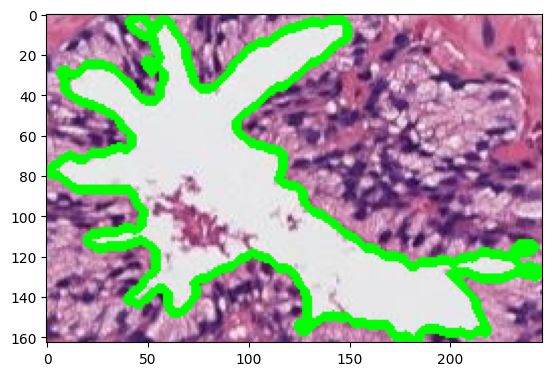

16

In [26]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
#Buscas el contorno más grande
lista_areas = []
image_copy = np.array(imagen)
for c in conts:
    area = cv2.contourArea(c)
    lista_areas.append(area)

#Te quedas con el area más grande
mas_grande = conts[lista_areas.index(max(lista_areas))]
index_max= lista_areas.index(max(lista_areas))
print(index_max)
#Representas el contorno más grande
area = cv2.contourArea(mas_grande)
print(area)
x,y,w,h = cv2.boundingRect(mas_grande)
print(x,y,w,h)
#Cropping
img_crop=img[y:y+h, x:x+w]
plt.imshow(img_crop, cmap='gray')
plt.show()

len(conts)

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [27]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad
from skimage.measure import label
from skimage.measure import regionprops
import math


lab, num = label(mask_fill.astype('uint8'), return_num=True)

objeto = lab == index_max
objeto = objeto.astype('uint8')
prop = regionprops(objeto.astype(np.uint8))

print(
f'''
1) Área = {np.round(prop[0].area, 4)}
2) Área de la bounding box = {np.round(prop[0].bbox_area, 4)}
3) Área convexa = {np.round(prop[0].convex_area, 4)}
4) Exentricidad = {np.round(prop[0].eccentricity, 4)}
5) Diámetro equivalente = {np.round(prop[0].equivalent_diameter, 4)}
6) Extensión = {np.round(prop[0].extent, 4)}
7) Diámetro Feret = {np.round(prop[0].feret_diameter_max, 4)}
8) Longitud del eje mayor = {np.round(prop[0].major_axis_length, 4)}
9) Longitud del eje menor = {np.round(prop[0].minor_axis_length, 4)}
10) Orientación = {np.round(prop[0].orientation, 4)}
11) Perímetro = {np.round(prop[0].perimeter, 4)}
12) Solidez = {np.round(prop[0].solidity, 4)}
13) Compacidad = {np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)}
''')


1) Área = 14110
2) Área de la bounding box = 40098
3) Área convexa = 29267
4) Exentricidad = 0.847
5) Diámetro equivalente = 134.0351
6) Extensión = 0.3519
7) Diámetro Feret = 259.0772
8) Longitud del eje mayor = 238.5271
9) Longitud del eje menor = 126.7963
10) Orientación = 1.0052
11) Perímetro = 1238.3189
12) Solidez = 0.4821
13) Compacidad = 0.1156



In [10]:
print(mask_fill.astype('uint8'))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


0) Cargar una de las imágenes histológicas

Las dimensiones de la imagen son: (1024, 1024, 3)


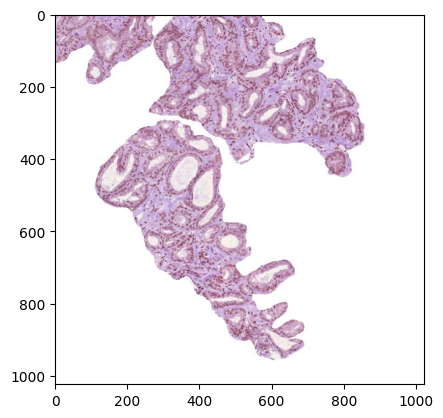

[[0.46836222 0.50054697 0.49619975 ... 0.         0.         0.        ]
 [0.43769832 0.47710509 0.49619975 ... 0.         0.         0.        ]
 [0.40134381 0.43532879 0.4839399  ... 0.         0.         0.        ]
 ...
 [1.         1.         1.         ... 0.         0.         0.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]]


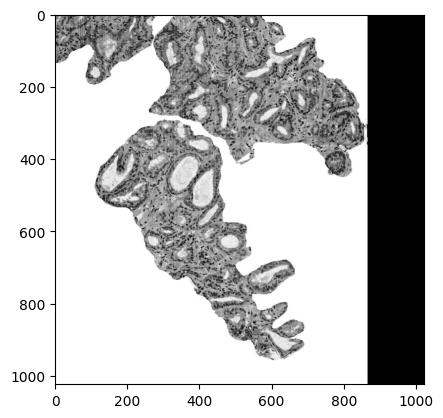

In [11]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
img2 = io.imread('histo_2.jpg')
RGB_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print('Las dimensiones de la imagen son:', np.shape(RGB_img2))
plt.imshow(RGB_img2, cmap='gray')
plt.show()
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
#Necesitamos convertir la imagen a blanco y negro para reducir la dimensionalidad a 2 para poder normalizar los valores.
from sklearn import preprocessing
from skimage import color
imgGray2 = color.rgb2gray(RGB_img2)
normalizer = preprocessing.MinMaxScaler()
img_norm2 = normalizer.fit_transform(imgGray2)
print(img_norm2)

#Visualizar la imagen
plt.imshow(img_norm2, cmap='gray')
plt.show()

1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

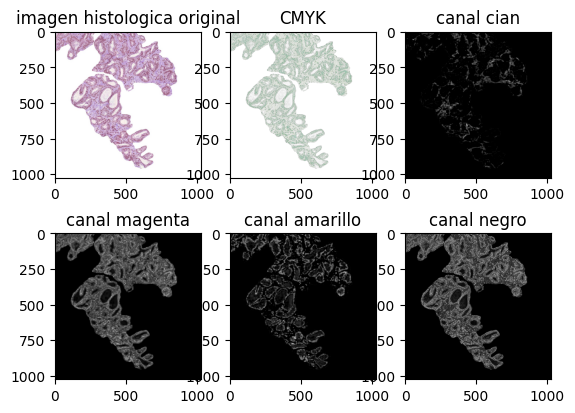

In [12]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
rgb2= RGB_img2.copy()
rgb_p2= rgb2.astype('uint8')/255
with np.errstate(invalid='ignore', divide='ignore'):
    K= 1 - np.max(rgb_p2, axis=2)
    #Extraemos el canal de color magenta en relacion a la siguiente ecuación:
    C= (1-rgb_p2[:,:,0]-K)/(1-K)
    M= (1-rgb_p2[:,:,1]-K)/(1-K)
    Y= (1-rgb_p2[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)
    
# Visualizar la imagen del canal magenta
fig, ax= plt.subplots(2,3)
ax[0,0].imshow(RGB_img2, cmap='gray'), ax[0,0].set_title('imagen histologica original')
ax[0,1].imshow(CMYK.astype('uint8'), cmap='gray'), ax[0,1].set_title('CMYK')
ax[0,2].imshow(C.astype('uint8'), cmap='gray'), ax[0,2].set_title('canal cian')
ax[1,0].imshow(M.astype('uint8'), cmap='gray'), ax[1,0].set_title('canal magenta')
ax[1,1].imshow(Y.astype('uint8'), cmap='gray'), ax[1,1].set_title('canal amarillo')
ax[1,2].imshow(K.astype('uint8'), cmap='gray'), ax[1,2].set_title('canal negro')
plt.show()

2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

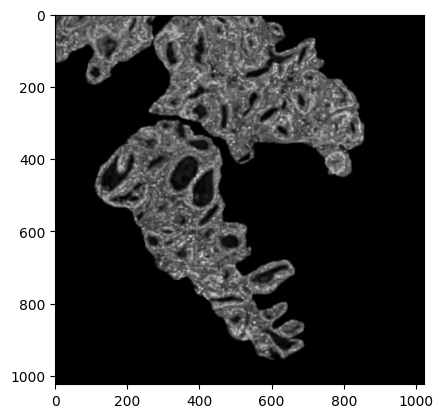

[0 1]


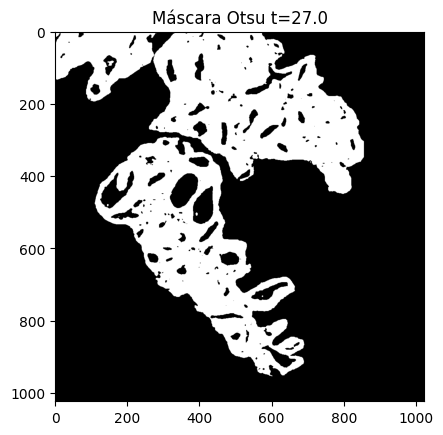

In [13]:
# Aplicar un filtro gaussiano de tamaño 5x5 
img_gaus2 = cv2.GaussianBlur(M.astype('uint8'), (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.imshow(img_gaus2, cmap='gray')
plt.show()

# Método de Otsu de manera que los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

t, mask2 = cv2.threshold(img_gaus2,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask2))

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask2, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

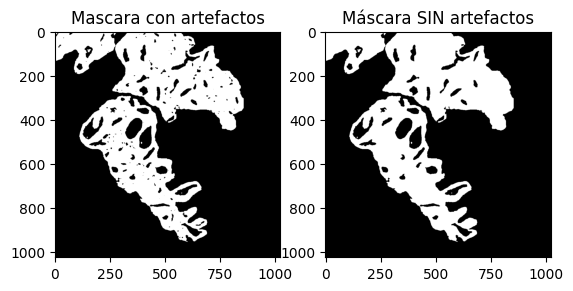

In [28]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
from skimage import morphology
mask_clean2= morphology.remove_small_objects(mask2, min_size=300).astype('bool')
mask_clean2= morphology.remove_small_holes(mask_clean2, area_threshold=300).astype('uint8')


# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizar la máscara resultante:
fig, ax= plt.subplots(1,2)
ax[0].imshow(mask2, cmap='gray'), ax[0].set_title('Mascara con artefactos')
ax[1].imshow(mask_clean2, cmap='gray'), ax[1].set_title('Máscara SIN artefactos')
plt.show()

4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

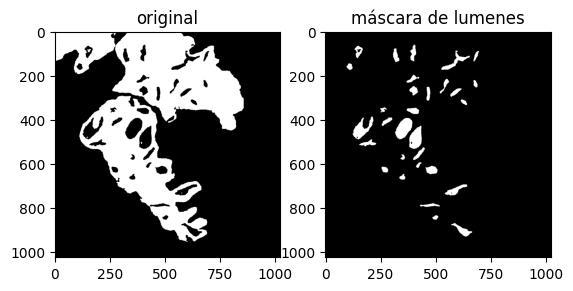

In [29]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

# Crear una copia de la imagen
mask_clean_c2 = mask_clean2.copy().astype('uint8')

# Definir una imagen negra de referencia
h, w = mask_clean_c2.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) y en la esquina inferior derecha (1000,1000).
cv2.floodFill(mask_clean_c2, ref, (0,0),1) # utilizamos el 0 en la última posición porque queremos obtener el fondo negro. Lumenes en blanco
cv2.floodFill(mask_clean_c2, ref, (1000,1000),1)

mask_final2 = np.logical_xor(mask_clean_c2,1).astype('uint8') # Se invierten los 1s por 0s
# Visualizar la máscara resultante. 
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_clean2, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask_final2, cmap='gray'), ax[1].set_title('máscara de lumenes')
plt.show()


5) Rellenar los objetos de los lúmenes

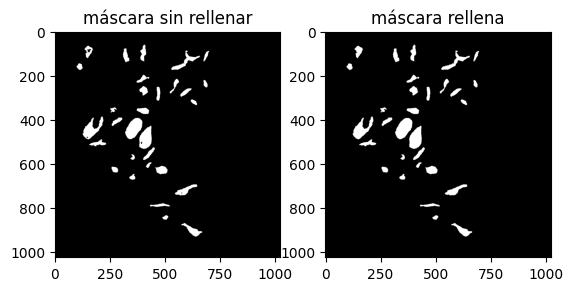

In [30]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
from scipy import ndimage
mask_fill2= ndimage.binary_fill_holes(mask_final2)
# Visualizar la máscara resultante
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_final2, cmap='gray'), ax[0].set_title('máscara sin rellenar')
ax[1].imshow(mask_fill2, cmap='gray'), ax[1].set_title('máscara rellena')
plt.show()

6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

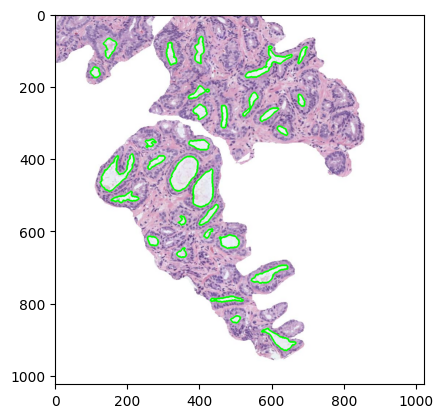

In [31]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Detección de bordes de Canny 
conts,_ = cv2.findContours(mask_fill2.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imagen2 = cv2.drawContours(img2, conts, -1, (0,255,0), 3)

# Visualizar la imagen superpuesta
plt.imshow(imagen2, cmap='gray')
plt.show()


7) Identificar y cropear el lumen más grande

[1836.0, 330.5, 736.0, 1884.5, 418.5, 562.5, 1441.0, 281.0, 270.5, 931.0, 987.0, 4190.5, 4769.0, 766.0, 3913.5, 1094.0, 328.0, 395.0, 765.0, 768.0, 950.0, 397.5, 700.5, 733.5, 525.0, 444.0, 2277.0, 998.5, 1131.0, 1134.5]
12
4769.0
318 394 78 96


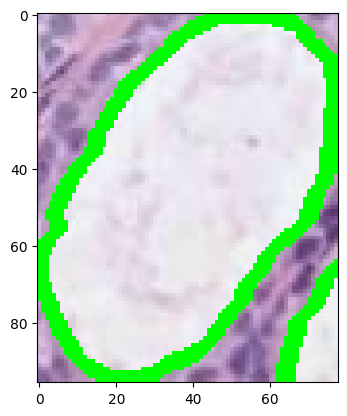

30

In [32]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
#Buscas el contorno más grande
lista_areas = []
image_copy = np.array(imagen2)
for c in conts:
    area = cv2.contourArea(c)
    lista_areas.append(area)
print(lista_areas)
#Te quedas con el area más grande
mas_grande = conts[lista_areas.index(max(lista_areas))]
index_max2= lista_areas.index(max(lista_areas))
print(index_max2)
#Representas el contorno más grande
area = cv2.contourArea(mas_grande)
print(area)
x,y,w,h = cv2.boundingRect(mas_grande)
print(x,y,w,h)
#Cropping
img_crop2=img2[y:y+h, x:x+w]
plt.imshow(img_crop2, cmap='gray')
plt.show()

len(conts)

8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [33]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad
from skimage.measure import label
from skimage.measure import regionprops
import math


lab, num = label(mask_fill2.astype('uint8'), return_num=True)

objeto = lab == index_max2
objeto = objeto.astype('uint8')
prop = regionprops(objeto.astype(np.uint8))

print(
f'''
1) Área = {np.round(prop[0].area, 4)}
2) Área de la bounding box = {np.round(prop[0].bbox_area, 4)}
3) Área convexa = {np.round(prop[0].convex_area, 4)}
4) Exentricidad = {np.round(prop[0].eccentricity, 4)}
5) Diámetro equivalente = {np.round(prop[0].equivalent_diameter, 4)}
6) Extensión = {np.round(prop[0].extent, 4)}
7) Diámetro Feret = {np.round(prop[0].feret_diameter_max, 4)}
8) Longitud del eje mayor = {np.round(prop[0].major_axis_length, 4)}
9) Longitud del eje menor = {np.round(prop[0].minor_axis_length, 4)}
10) Orientación = {np.round(prop[0].orientation, 4)}
11) Perímetro = {np.round(prop[0].perimeter, 4)}
12) Solidez = {np.round(prop[0].solidity, 4)}
13) Compacidad = {np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)}
''')


1) Área = 823
2) Área de la bounding box = 1938
3) Área convexa = 882
4) Exentricidad = 0.9566
5) Diámetro equivalente = 32.3709
6) Extensión = 0.4247
7) Diámetro Feret = 60.7454
8) Longitud del eje mayor = 60.5939
9) Longitud del eje menor = 17.6574
10) Orientación = -0.94
11) Perímetro = 138.8528
12) Solidez = 0.9331
13) Compacidad = 0.5364

